## Analysis of insolvencies amongst aid beneficiaries

In [2]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
insolvencies = pd.read_csv('/Users/marco/Library/CloudStorage/OneDrive-HertieSchool/Thesis/Programming/insolvenzen.csv')
aid_df = pd.read_csv('data/main/aid_dataset.csv')
merged_df = pd.read_csv('data/main/data_set.csv')

In [4]:
insolvencies.drop_duplicates(subset='Name, Vorname / Bezeichnung',keep='first',inplace=True)
insolvencies['Name, Vorname / Bezeichnung'] = insolvencies['Name, Vorname / Bezeichnung'].str.lower()

preview of the insolvencies data

In [4]:
insolvencies.head(3)

,Unnamed: 0,Veröffent­lichungsdatum,aktuelles Aktenzeichen,Gericht,"Name, Vorname / Bezeichnung",Sitz / Wohnsitz,Register,Veröffentlichungstext anzeigen
0,0,02.01.2021,6 IN 149/19,Gießen,golfpark schlossgut sickendorf gmbh,Lauterbach (Hessen),"Gießen, HRB 8710",NaN
1,0,03.01.2021,83 IN 358/20,Heidelberg,vibroplan gmbh,Sandhausen,"Mannheim, HRB 720267",NaN
2,0,04.01.2021,107 IN 27/20,Saarbrücken,"""camion blue"" modevertrieb gmbh",Saarbrücken,"Saarbrücken, HRB HRB 74867",NaN


### Look at all disclosed aid beneficiaries

In [5]:
df_all = aid_df.merge(insolvencies, 
                how='left', 
                left_on='company', 
                right_on='Name, Vorname / Bezeichnung')

In [7]:
df_all.to_csv('data/main/data_set_insolvencies.csv', encoding='utf-8', index=False)

In [150]:
df_all['aid_loan_2020'].replace(np.nan, 0, inplace=True)
df_all['aid_loan_2021'].replace(np.nan, 0, inplace=True)
df_all['aid_loan_2022'].replace(np.nan, 0, inplace=True)
df_all['aid_grant_2020'].replace(np.nan, 0, inplace=True)
df_all['aid_grant_2021'].replace(np.nan, 0, inplace=True)
df_all['aid_grant_2022'].replace(np.nan, 0, inplace=True)
df_all['aid_grant_2023'].replace(np.nan, 0, inplace=True)

df_all['loan_amount'] = df_all['aid_loan_2020'] + df_all['aid_loan_2021'] + df_all['aid_loan_2022']
df_all['grant_amount'] = df_all['aid_grant_2020'] + df_all['aid_grant_2021'] + df_all['aid_grant_2022'] + df_all['aid_grant_2023']

In [151]:
df_all2 = df_all[['loan_amount','grant_amount','size','industry','Veröffent­lichungsdatum']]
df_all2['survival'] = np.where(df_all2['Veröffent­lichungsdatum'].isna() , 'solvent', 'insolvent')
df_all2

,loan_amount,grant_amount,size,industry,Veröffent­lichungsdatum,survival
0,100000.0,0.00,Kleine und mittlere Unternehmen,47,NaN,solvent
1,300000.0,0.00,nur Großunternehmen,52,NaN,solvent
2,200000.0,0.00,Kleine und mittlere Unternehmen,47,NaN,solvent
3,400000.0,0.00,nur Großunternehmen,55,NaN,solvent
4,500000.0,0.00,nur Großunternehmen,49,NaN,solvent
...,...,...,...,...,...,...
103331,0.0,804177.00,Kleine und mittlere Unternehmen,10,NaN,solvent
103332,0.0,275386.00,Kleine und mittlere Unternehmen,79,NaN,solvent
103333,0.0,153945.99,Kleine und mittlere Unternehmen,46,NaN,solvent
103334,500000.0,0.00,nur Großunternehmen,29,NaN,solvent


#### By size

In [236]:
df_by_size = df_all2.pivot_table(index=['size'], columns=['survival'], values=['industry'],aggfunc='count', margins=True, margins_name='aid beneficiaries')#.reset_index()
df_by_size = df_by_size.droplevel(0, axis=1).reset_index()
df_by_size['share'] = df_by_size['insolvent'] / df_by_size['aid beneficiaries']
df_by_size['share'] = df_by_size['share'].map(lambda n: '{:.2%}'.format(n))
df_by_size = df_by_size[['size','aid beneficiaries','insolvent','share']]
df_by_size

survival,size,aid beneficiaries,insolvent,share
0,Kleine und mittlere Unternehmen,78077,526,0.67%
1,nur Großunternehmen,25259,427,1.69%
2,aid beneficiaries,103336,953,0.92%


In [237]:
df_by_size.at[0,'size'] = 'SMEs'
df_by_size.at[1,'size'] = 'Large companies'
df_by_size.at[2,'size'] = 'Total'

In [ ]:
with open('/Users/marco/Library/CloudStorage/OneDrive-HertieSchool/Thesis/GitHub/thesis/paper/Tables/table_InsBySize.tex', 'w') as f:
     f.write(df_by_size.to_latex(bold_rows=True, index=False))

#### By industry

Preparation for transforming NACE codes
\
Source of NACE_ENG.csv:
\
https://ec.europa.eu/eurostat/ramon/nomenclatures/index.cfm?TargetUrl=LST_CLS_DLD&StrNom=NACE_REV2&StrLanguageCode=EN&StrLayoutCode=HIERARCHIC#

In [155]:
nace_eng = pd.read_csv('NACE_ENG.csv',encoding='utf-8-sig', delimiter=',',usecols = ['Code','Description'])
nace_eng.at[0,'Code'] = '01'
nace_eng['Code'] = nace_eng['Code'].astype(str)

In [156]:
df_by_industry = df_all2.pivot_table(index=['industry'], columns=['survival'], values=['size'],aggfunc='count', margins=True, margins_name='beneficiaries')#.reset_index()
df_by_industry = df_by_industry.droplevel(0, axis=1).reset_index()
df_by_industry['share'] = df_by_industry['insolvent'] / df_by_industry['beneficiaries']
df_by_industry.sort_values(by=['share'],ascending=False,inplace=True)
df_by_industry['share'] = df_by_industry['share'].map(lambda n: '{:.2%}'.format(n))
df_by_industry = df_by_industry[df_by_industry["beneficiaries"] > 500]
df_by_industry = df_by_industry[['industry','beneficiaries','insolvent','share']]
df_by_industry['industry'] = df_by_industry['industry'].astype(str)

df_by_industry = df_by_industry.merge(nace_eng, 
                how='left', 
                left_on='industry', 
                right_on='Code')

df_by_industry['industry'] = df_by_industry['Description']


df_by_industry.drop(['Description','Code'],axis=1)
df_by_industry = df_by_industry[df_by_industry['industry'].notnull()]
df_by_industry = df_by_industry[['industry','beneficiaries','insolvent','share']]
df_by_industry['industry'] = df_by_industry['industry'].astype(str).str[:40]
df_by_industry

,industry,beneficiaries,insolvent,share
0,Employment activities,594,30.0,5.05%
1,Construction of buildings,1247,37.0,2.97%
2,Manufacture of basic metals,586,14.0,2.39%
3,"Computer programming, consultancy and re",1481,35.0,2.36%
4,Manufacture of machinery and equipment n,2226,44.0,1.98%
5,"Manufacture of computer, electronic and",728,13.0,1.79%
6,Specialised construction activities,4103,68.0,1.66%
7,Manufacture of rubber and plastic produc,664,10.0,1.51%
8,Printing and reproduction of recorded me,826,11.0,1.33%
9,Other manufacturing,689,9.0,1.31%


In [ ]:
with open('/Users/marco/Library/CloudStorage/OneDrive-HertieSchool/Thesis/GitHub/thesis/paper/Tables/table_InsByIndustry.tex', 'w') as f:
     f.write(df_by_industry.to_latex(bold_rows=True, index=False, float_format="%.0f"))

In [158]:
df_by_industry_short = df_by_industry

df_by_industry_short.sort_values(by=['insolvent'],ascending=False,inplace=True)
#df_by_industry['share'] = df_by_industry['share'].map(lambda n: '{:.2%}'.format(n))
df_by_industry_short = df_by_industry_short[df_by_industry_short["beneficiaries"] > 3000]

df_by_industry_short

,industry,beneficiaries,insolvent,share
27,Food and beverage service activities,15173,88.0,0.58%
19,"Retail trade, except of motor vehicles a",8810,84.0,0.95%
6,Specialised construction activities,4103,68.0,1.66%
15,"Wholesale trade, except of motor vehicle",5396,56.0,1.04%
11,Manufacture of fabricated metal products,3105,40.0,1.29%
22,"Office administrative, office support an",3040,28.0,0.92%
29,Sports activities and amusement and recr,5232,27.0,0.52%
36,Accommodation,9885,24.0,0.24%
31,Wholesale and retail trade and repair of,3525,17.0,0.48%


In [ ]:
with open('/Users/marco/Library/CloudStorage/OneDrive-HertieSchool/Thesis/GitHub/thesis/paper/Tables/table_InsByIndustry_short.tex', 'w') as f:
     f.write(df_by_industry_short.to_latex(bold_rows=True, index=False, float_format="%.0f"))

### Look at aid beneficiaries with available financial information

In [152]:
df_kpi = merged_df.merge(insolvencies, 
                how='left', 
                left_on='company', 
                right_on='Name, Vorname / Bezeichnung')

#### DiD on Method on data subset

In [153]:
df_kpi_subset = df_kpi[df_kpi['Veröffent­lichungsdatum'].notnull()]

In [320]:
df_kpi_subset = df_kpi_subset.rename(columns={'debt/equity_ratio_2019' : 'debtxtoxequity_ratio_2019', 
                                        'debt/asset_ratio_2019' : 'debtxtoxassest_ratio_2019',
                                        'debt/equity_ratio_2020' : 'debtxtoxequity_ratio_2020', 
                                        'debt/asset_ratio_2020' : 'debtxtoxassest_ratio_2020',
                                        'debt/equity_ratio_2021' : 'debtxtoxequity_ratio_2021', 
                                        'debt/asset_ratio_2021' : 'debtxtoxassest_ratio_2021',
                                        })

In [321]:
ratios = ['cash_ratio','quick_ratio','current_ratio','debtxtoxequity_ratio','equity_ratio','debtxtoxassest_ratio']
types = ['aid_grant','aid_loan']

In [322]:
results_dict = {}
#loop over year
for year in [2020,2021]:

    for id, type in enumerate(types, start=1):
        type_inverse_year = types[id-2] + '_' + str(year)
        type_year = type + '_' + str(year)
        data_unconfounded = df_kpi_subset[df_kpi_subset[type_inverse_year].isnull()]

        #loop over ratio
        if year == 2021: # Remove companies that received other aid due to possible confounding
                data_unconfounded = data_unconfounded[data_unconfounded[('aid_grant'+'_'+ str(year-1))].isnull()] ###
                data_unconfounded = data_unconfounded[data_unconfounded[('aid_loan'+'_'+ str(year-1))].isnull()] ###
        
        results = {}
        

        for ratio in ratios:
            ratio_year_prior = ratio + '_' + str(year-1)
            ratio_year = ratio + '_' + str(year)

            data_dd = data_unconfounded[[ratio_year_prior , ratio_year, type_year]]
            data_dd['treatment_group'] = np.where(data_dd[type_year].isna() , 0, 1)
            data_dd = data_dd.drop(type_year, axis=1)
            data_dd.replace([np.inf, -np.inf], np.nan, inplace=True)
            data_dd = data_dd.dropna()

            #remove outliers
            #data_dd = data_dd[data_dd[ratio_year_prior].between(*data_dd[ratio_year_prior].quantile([0.05, 0.95]).tolist())]
            #data_dd = data_dd[data_dd[ratio_year].between(*data_dd[ratio_year].quantile([0.05, 0.95]).tolist())]

            # data before the treatment
            df_before = data_dd[[ratio_year_prior, 'treatment_group']]
            df_before['t'] = 0
            df_before.columns = [ratio, 'treatment_group', 'time']

            # data after the treatment
            df_after = data_dd[[ratio_year, 'treatment_group']]
            df_after['t'] = 1
            df_after.columns = [ratio, 'treatment_group', 'time']

            # data for regression
            df_reg = pd.concat([df_before, df_after])

            # create the interaction 
            df_reg['interaction'] = df_reg.treatment_group * df_reg.time

            # drop extrem outliers
            df_reg = df_reg[df_reg[ratio] > 0 ]
            df_reg = df_reg.drop(df_reg[df_reg[ratio] > df_reg[ratio].quantile(.95)].index)
            

            from statsmodels.formula.api import ols
            formular = ratio + ' ~ treatment_group + time + interaction' 
            
            try:
                ols = ols(formular, data=df_reg).fit()
                cov = ols.params['interaction'].round(4)
                pv =  ols.pvalues['interaction'].round(3)
                
                if pv >= 0.1:
                    pv = ("%.3f" % pv)           
                    pv = "\space\space\space\space("+str(pv)+")"
                elif (pv < 0.1) and ((pv > 0.05)):
                    pv = ("%.3f" % pv)           
                    pv = "*\space\space\space("+str(pv)+")"
                elif (pv < 0.05) and ((pv > 0.01)):
                    pv = ("%.3f" % pv)           
                    pv = "**\space\space("+str(pv)+")"
                elif pv < 0.01:
                    pv = ("%.3f" % pv)           
                    pv = "***\space("+str(pv)+")"

                ratio = ratio.replace("_", " ").replace("x", " ")
                results[ratio] = ''.join((str(cov),pv))

            except:
                pass

        results_dict[type_year] = results

In [323]:
df_results = pd.DataFrame.from_dict(results_dict, orient='index')
df_results.index.name='aid_instrument_year'
df_results.reset_index(inplace=True)
new_col = df_results['aid_instrument_year'].str.split('_',expand=True)
df_results['instrument'] = new_col[1]
df_results['year'] = new_col[2]
df_results.drop(columns =["aid_instrument_year"], inplace = True)
df_results.set_index(['year', 'instrument'],inplace=True)
df_results

cash ratio  \
year instrument                                           
2020 grant        -0.038\space\space\space\space(0.605)   
     loan                   0.0427**\space\space(0.046)   
2021 grant        0.1469\space\space\space\space(0.337)   
     loan        -0.1302\space\space\space\space(0.394)   

                                           quick ratio  \
year instrument                                          
2020 grant       0.2732\space\space\space\space(0.645)   
     loan        0.1349\space\space\space\space(0.493)   
2021 grant       0.4531\space\space\space\space(0.598)   
     loan        0.2365\space\space\space\space(0.728)   

                                          current ratio  \
year instrument                                           
2020 grant        0.2117\space\space\space\space(0.759)   
     loan         0.0444\space\space\space\space(0.848)   
2021 grant        0.3419\space\space\space\space(0.666)   
     loan        -0.0784\space\space\space\space(0.930)   

                                   debt to equity ratio  \
year instrument                                           
2020 grant       -3.9105\space\space\space\space(0.867)   
     loan         2.0475\space\space\space\space(0.262)   
2021 grant        1.0318\space\space\space\space(0.588)   
     loan         6.8704\space\space\space\space(0.663)   

                                           equity ratio  \
year instrument                                           
2020 grant        0.0889\space\space\space\space(0.588)   
     loan        -0.0338\space\space\space\space(0.381)   
2021 grant       -0.1444\space\space\space\space(0.405)   
     loan        -0.2779\space\space\space\space(0.467)   

                                   debt to assest ratio  
year instrument                                          
2020 grant        0.0797\space\space\space\space(0.650)  
     loan              0.0892*\space\space\space(0.080)  
2021 grant       -0.0763\space\space\space\space(0.728)  
     loan         0.1806\space\space\space\space(0.580)

In [ ]:
with open('/Users/marco/Library/CloudStorage/OneDrive-HertieSchool/Thesis/GitHub/thesis/paper/Tables/table_did_insolv.tex', 'w') as f:
     f.write(df_results.transpose().stack().to_latex(index=True, bold_rows=True, column_format='llrr',multirow=True ,formatters={'white-space': 'pre'}, escape=False))

#### Ratio comparison with boxplots

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
df_boxplot = df_kpi

In [7]:
df_kpi.head(1)

,company,assets_2018,assets_2019,assets_2020,assets_2021,cash_2018,cash_2019,cash_2020,cash_2021,cash_ratio_2018,...,industry_1,industry_2,Unnamed: 0,Veröffent­lichungsdatum,aktuelles Aktenzeichen,Gericht,"Name, Vorname / Bezeichnung",Sitz / Wohnsitz,Register,Veröffentlichungstext anzeigen
0,"""capillar gmbh""",2332299.34,NaN,2732777.71,NaN,36787.77,NaN,233693.31,NaN,0.015773,...,Handel; Instandhaltung und Reparatur von Kraft...,Einzelhandel (ohne Handel mit Kraftfahrzeugen),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_boxplot['survival'] = np.where(df_boxplot['Veröffent­lichungsdatum'].isna() , 'solvent', 'insolvent')
df_boxplot.columns = df_boxplot.columns.str.split("_",expand=True)
df_boxplot.set_index('company', inplace=True)
df_boxplot.drop(['Unnamed: 0','Veröffent­lichungsdatum','aktuelles Aktenzeichen','Gericht','Name, Vorname / Bezeichnung','Sitz / Wohnsitz','Register','Veröffentlichungstext anzeigen'], axis=1,inplace=True)

In [25]:
bxp_li = pd.concat([df_boxplot.survival, df_boxplot.cash.ratio],axis=1)
bxp_li['group'] = bxp_li[(np.nan, np.nan)]
bxp_li.drop([(np.nan, np.nan)],axis=1,inplace=True)
bxp_li = bxp_li.melt(id_vars='group')
bxp_li[bxp_li.value < 0] = np.nan

In [57]:
bxp_debt = pd.concat([df_boxplot.survival, df_boxplot['debt/asset'].ratio],axis=1)
bxp_debt['group'] = bxp_debt[(np.nan, np.nan)]
bxp_debt.drop([(np.nan, np.nan)],axis=1,inplace=True)
bxp_debt = bxp_debt.melt(id_vars='group')
bxp_debt[bxp_debt.value < 0] = np.nan

[Text(0.5, 0, ''), Text(0, 0.5, '')]

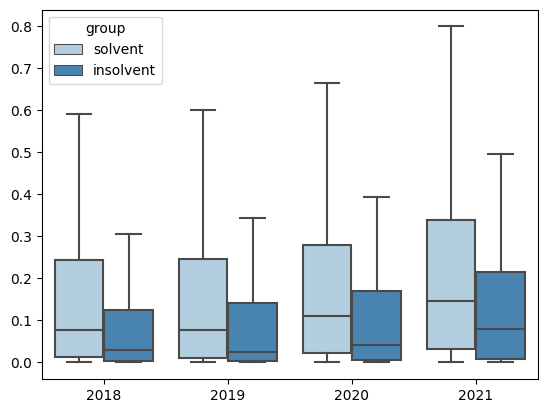

In [50]:
sns.boxplot(x = bxp_li.variable,
            y = bxp_li.value,
            hue = bxp_li.group,
            showfliers=False,
            palette='Blues').set(xlabel=None,ylabel=None)


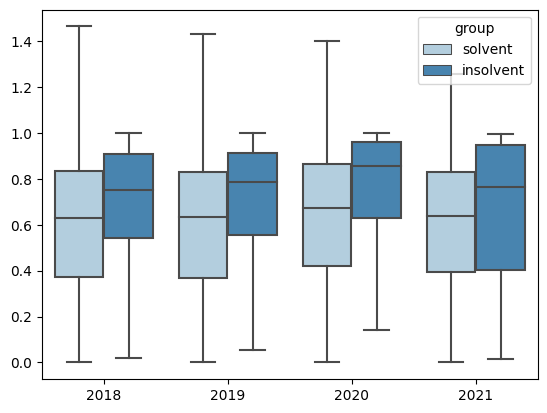

In [65]:
ax3 = sns.boxplot(x = bxp_debt.variable,
            y = bxp_debt.value,
            hue = bxp_debt.group,
            showfliers=False,
            palette='Blues').set(xlabel=None,ylabel=None)

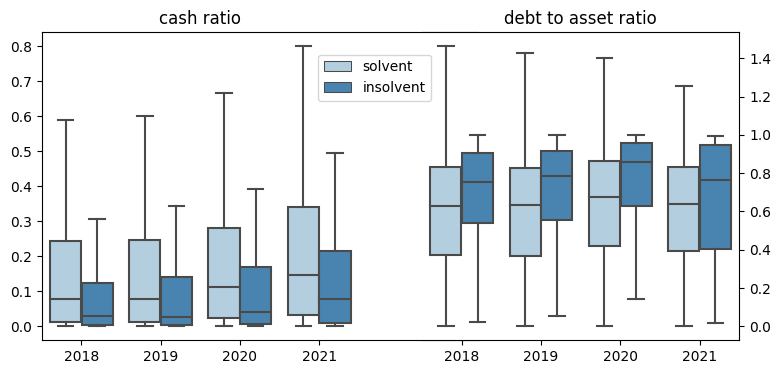

In [148]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
sns.boxplot(ax=ax2, x = bxp_debt.variable,
            y = bxp_debt.value,
            hue = bxp_debt.group,
            showfliers=False,
            palette='Blues').set(xlabel=None,ylabel=None)
sns.boxplot(ax=ax1, x = bxp_li.variable,
            y = bxp_li.value,
            hue = bxp_li.group,
            showfliers=False,
            palette='Blues').set(xlabel=None,ylabel=None)
ax1.get_legend().remove()
ax2.legend(bbox_to_anchor=(0.05, 0.95))
ax1.spines["right"].set_visible(False)
ax2.yaxis.tick_right()
ax2.spines["left"].set_visible(False)
ax1.spines["top"].set_bounds(-0.5,5)
ax1.spines["bottom"].set_bounds(-0.5,5)
ax1.set(title='cash ratio')
ax2.set(title='debt to asset ratio')

fig.savefig("paper/Figures/chart_ratios_insolvence.png") 